## Part 1: Fully Bayesian inference for Gaussian process regression ##

First we load in the the data and preprocess it.

In [1]:
import numpy as np

# load data from disk
data = np.load('./data_exercise5b.npz')
X = data['day']
y = np.log(data['bike_count'])
# remove mean and scale to unit variance
ym, ys = np.mean(y), np.std(y)
y = (y-ym)/ys

### Task 1.2 ###
We know that the lengthscale has a prior distribution of $\mathcal{N}_+(0,v)$. We wish to find the value of $v$ such that $p(l>100) \approx 0.01$. This will be done numerically. To do this we will use the CDF function in the scipy.stats.halfnorm package. By saying 1 - CDF we will find the probability that the lengthscale is greater than 100 for a given scale.

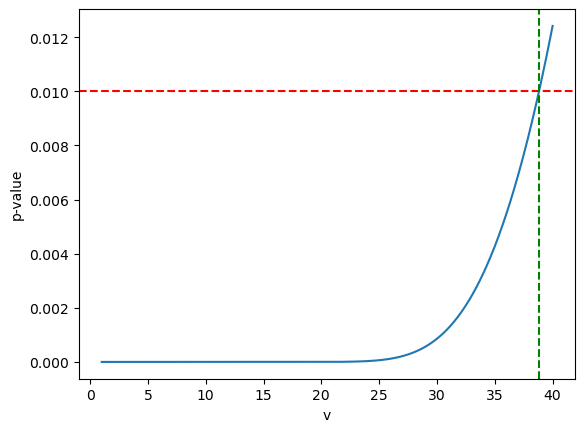

v = 38.83


In [2]:
from scipy.stats import halfnorm, multivariate_normal
import matplotlib.pyplot as plt

vs = np.linspace(1, 40, 10000)
ps = 1 - halfnorm.cdf(100, scale=vs)
v = vs[np.argmax(ps > 0.01)]

# plot the p-values
plt.plot(vs, ps)   
plt.xlabel('v')
plt.ylabel('p-value')
plt.axhline(0.01, color='r', linestyle='--')
plt.axvline(v, color='g', linestyle='--')
plt.show()

print(f'v = {v:.2f}')

We see that the value of $v$ is approximately 38.83.

### Task 1.3 ###

We will now compute the distribution of $p(\mathbf{y},\sigma,\kappa, l)$ by marginalizing out $\mathbf{f}$ from the joint distribution $p(\mathbf{y},\mathbf{f},\sigma,\kappa, l)$. We will do this by first isolating the terms dependent on $\mathbf{f}$ and then using equation 3.38 from Murphy 1.

$$
\begin{align*}
    p(\mathbf{y},\sigma,\kappa, l) &= \int p(\mathbf{y},\mathbf{f},\sigma,\kappa, l) d\mathbf{f} \\
    &= \int p(\mathbf{y}|\mathbf{f},\sigma^2) p(\mathbf{f}|\kappa, l) p(\sigma) p(\kappa) p(l) d\mathbf{f} \\
    &= \int \mathcal{N}(\mathbf{y}|\mathbf{f},\sigma^2I) \mathcal{N}(\mathbf{f}|0,\mathbf{K}) \mathcal{N}_+(\sigma|0,1) \mathcal{N}_+(\kappa|0,1) \mathcal{N}_+(l|0,v) d\mathbf{f} \\
    &= \mathcal{N}_+(\sigma|0,1) \mathcal{N}_+(\kappa|0,1) \mathcal{N}_+(l|0,v) d\mathbf{f} \int \mathcal{N}(\mathbf{y}|\mathbf{f},\sigma^2I) \mathcal{N}(\mathbf{f}|0,\mathbf{K}) d\mathbf{f} \\
    &= \mathcal{N}(\mathbf{y}|\mathbf{0}, \sigma^2\mathbf{I} + \mathbf{K}) \mathcal{N}_+(\sigma|0,1) \mathcal{N}_+(\kappa|0,1) \mathcal{N}_+(l|0,v)
\end{align*}
$$

### Task 1.4 ###

We start by defining the given information about the parameters and then initializing some random starting points for the parameters.

In [3]:
v = 38.83
num_chains = 4
num_iter = 10000
num_params = 3

theta_init = np.vstack([halfnorm.rvs(size = num_chains), halfnorm.rvs(scale=np.sqrt(v), size = num_chains), halfnorm.rvs(size = num_chains)]).T

proposal_variance = 0.5
warm_up = 1000
seed = 0

Now we define a class and a function from previous exercises in this course. The StationaryIsotropicKernel which we will use to construct the matrix $K$ calcuated from the given kernel function. We will also the metropolis_multiple_chains algorithm, which will approximate the posterior distribution over the hyperparameters $p(\kappa, l,\sigma|\mathbf{y})$.

In [4]:
from exercise9 import compute_effective_sample_size
from exercise9 import compute_Rhat
from exercise9 import metropolis

class StationaryIsotropicKernel(object):

    def __init__(self, kernel_fun, kappa=1., lengthscale=1.0):
        """
            the argument kernel_fun must be a function of three arguments kernel_fun(||tau||, kappa, lengthscale), e.g. 
            squared_exponential = lambda tau, kappa, lengthscale: kappa**2*np.exp(-0.5*tau**2/lengthscale**2)
        """
        self.kernel_fun = kernel_fun
        self.kappa = kappa
        self.lengthscale = lengthscale

    def contruct_kernel(self, X1, X2, kappa=None, lengthscale=None, jitter=1e-8):
        """ compute and returns the NxM kernel matrix between the two sets of input X1 (shape NxD) and X2 (MxD) using the stationary and isotropic covariance function specified by self.kernel_fun
    
        arguments:
            X1              -- NxD matrix
            X2              -- MxD matrix
            kappa           -- magnitude (positive scalar)
            lengthscale     -- characteristic lengthscale (positive scalar)
            jitter          -- non-negative scalar
        
        returns
            K               -- NxM matrix    
        """

        # extract dimensions 
        N, M = X1.shape[0], X2.shape[0]

        # prep hyperparameters
        kappa = self.kappa if kappa is None else kappa
        lengthscale = self.lengthscale if lengthscale is None else lengthscale

        ##############################################
        # Your solution goes here
        ##############################################

        # compute all the pairwise distances efficiently
        dists = np.sqrt(np.sum((np.expand_dims(X1, 1) - np.expand_dims(X2, 0))**2, axis=-1))
        
        # squared exponential covariance function
        K = self.kernel_fun(dists, kappa, lengthscale)
        
        # add jitter to diagonal for numerical stability
        if len(X1) == len(X2) and np.allclose(X1, X2):
            K = K + jitter*np.identity(len(X1))

        ##############################################
        # End of solution
        ##############################################
        
        assert K.shape == (N, M), f"The shape of K appears wrong. Expected shape ({N}, {M}), but the actual shape was {K.shape}. Please check your code. "
        return K

def squared_exponential(tau, kappa, lengthscale):
    return kappa**2*np.exp(-0.5*tau**2/lengthscale**2)

N = len(y)

def log_target(x):
    kappa, l, sigma = x

    kernel_class = StationaryIsotropicKernel(squared_exponential, kappa=kappa, lengthscale=l)

    K = kernel_class.contruct_kernel(X, X, jitter=1e-4)

    log_lik = multivariate_normal.logpdf(y.squeeze(), mean=np.zeros(N), cov=K + sigma**2*np.eye(N))

    log_prior = halfnorm.logpdf(kappa,0,1) + halfnorm.logpdf(l,0,v) + halfnorm.logpdf(sigma,0,1)

    return log_lik + log_prior

def metropolis_multiple_chains(log_target, num_params, num_chains, tau, num_iter, theta_init, warm_up=0, seed=0):
    """ Runs multiple Metropolis-Hastings chains. The i'th chain should be initialized using the i'th vector in theta_init, i.e. theta_init[i, :]

    Arguments:
        log_target:         function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        num_chains:         number of MCMC chains
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations for each chain (integer)
        theta_init:         array of initial values (np.array with shape (num_chains, num_params))        
        warm_up:            number of warm up samples to be discarded
        seed:               seed (integer)
    
    returns:
        thetas              np.array of samples from each chain after warmup (shape: num_chains x (num_iter + 1 - warm_up))
        accept_rates        np.array of acceptances rate for each chain (shapes: num_chains)
    
     """
    
    # set seed
    np.random.seed(seed)

    # verify dimension of initial parameters 
    assert theta_init.shape == (num_chains, num_params), "theta_init seems to have the wrong dimensions. Plaese check your code."

    ##############################################
    # Your solution goes here
    ##############################################
    # prepare arrays for storing samples
    thetas = np.zeros((num_chains, num_iter+1, num_params))
    accept_rates = np.zeros(num_chains)    

    # run sampler for each chain
    for idx_chain in range(num_chains):
        thetas[idx_chain, :, :], accept_rates[idx_chain] = metropolis(log_target, num_params, tau, num_iter, theta_init=theta_init[idx_chain])

    # discard warm-up samples
    thetas = thetas[:, warm_up:, :]  

    ##############################################
    # End of solution
    ##############################################

    # verify dimensions and return
    assert thetas.shape == (num_chains, num_iter+1-warm_up, num_params), f"The expected shape of chains is ({num_chains}, {num_iter+1-warm_up}, {num_params}) corresponding to (num_chains, num_iter+1-warm_up), but the actual shape is {thetas.shape}. Check your implementation."
    assert len(accept_rates) == num_chains
    return thetas, accept_rates


After having defined all relevant classes and functions we will run the metropolis_multiple_chains algorithm for 10000 iterations with 4 different chains.

In [5]:
# sample
chains, accepts = metropolis_multiple_chains(log_target, num_params, num_chains, proposal_variance, num_iter, theta_init, warm_up, seed)

c:\Users\AdrianLopez\anaconda3\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


### Task 1.5 - 1.7 ###
In the previous part we ran four chains for 10000 iterations. The first 1000 iterations were discared as warmup.

Now that we have the four chains we can plot the trace for each parameter to see if they have converged along with reporting other relevant statistics. First we compute all relevant statistics that will be needed later.

In [6]:
S_eff = compute_effective_sample_size(chains)
Rhat = compute_Rhat(chains)

# make x space for each parameter
x_space = np.vstack([np.linspace(0.1, 4, 100), np.linspace(0.1,50,100), np.linspace(0.1, 2, 100)]).T

# remember to compute the estimated mean for each parameter and index in the plot
estimated_mean = np.mean(np.mean(chains, axis=0), axis=0)
estimated_var = np.var(np.var(chains, axis=0), axis=0)
estimated_std = np.sqrt(estimated_var)

MC_error = estimated_std/np.sqrt(S_eff)

Next we can plot the trace for each parameter. In the title we also state the convergence diagnostics $\hat{R}$ and the effective sample size ${S_{eff}}$.

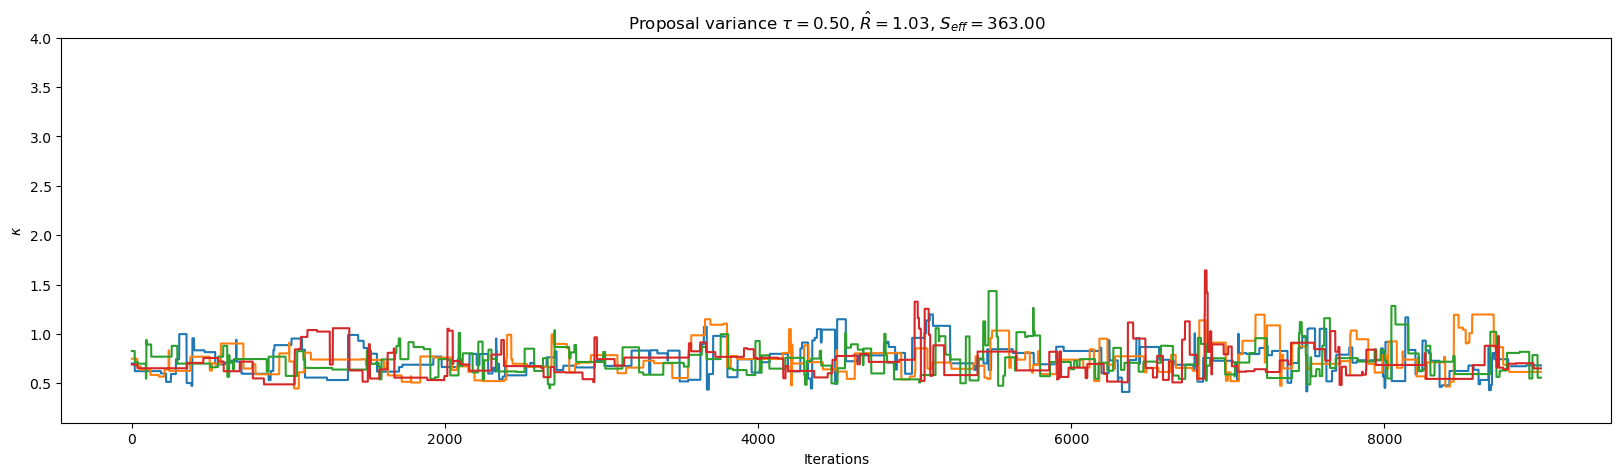

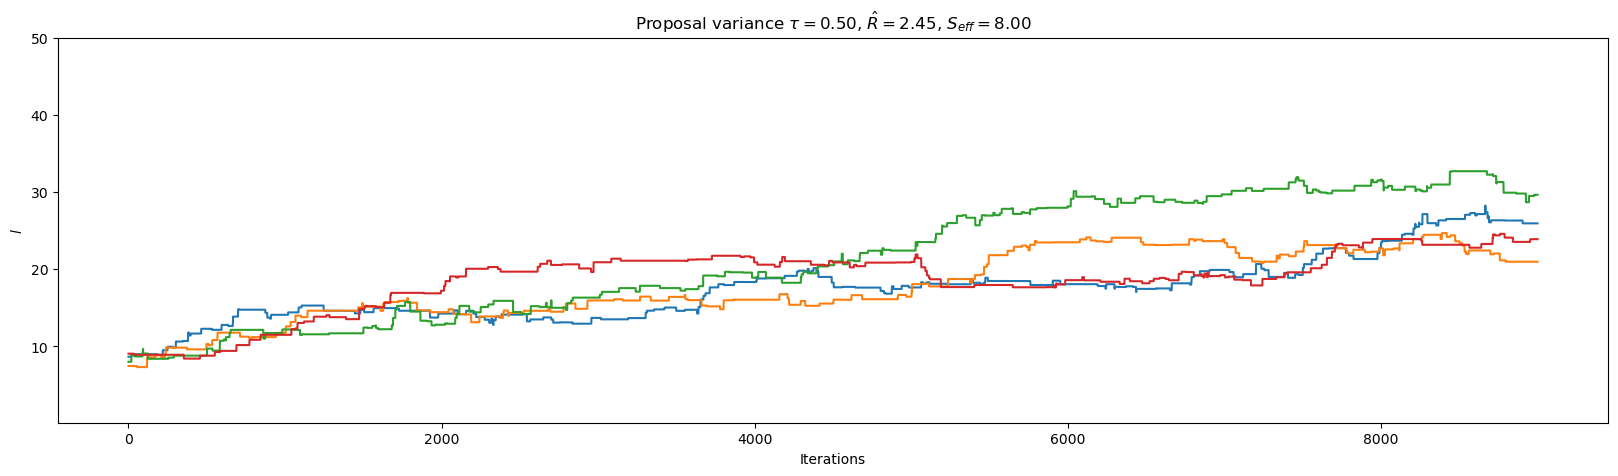

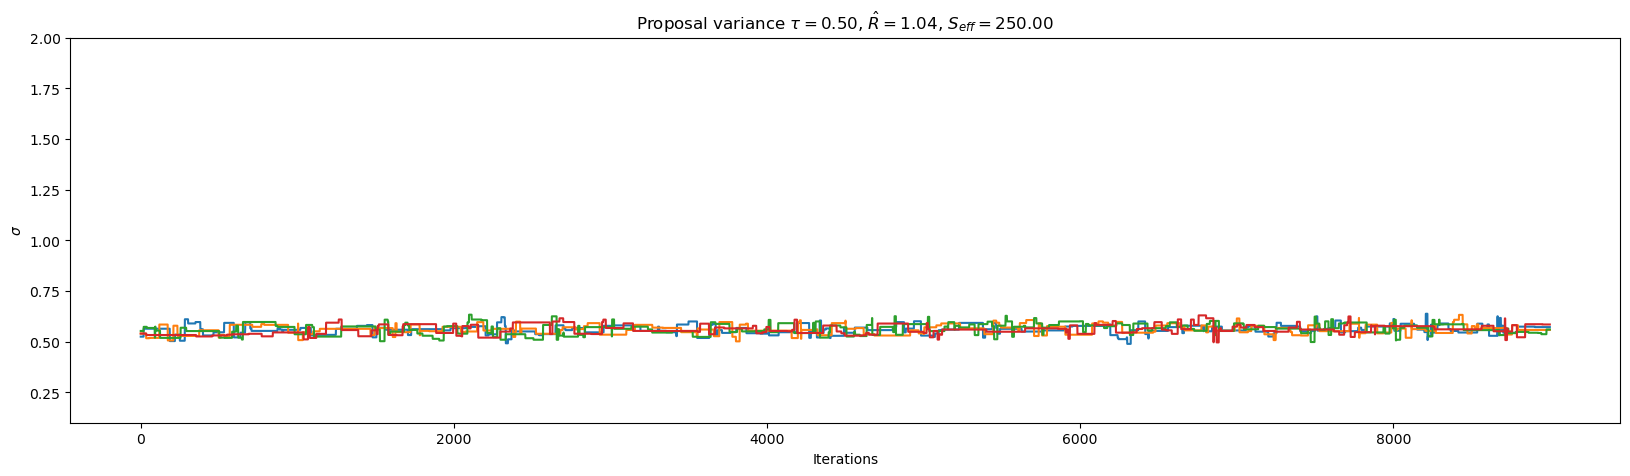

In [7]:
# ignore Syntaxwarnings
import warnings
warnings.filterwarnings("ignore")

ylabels = ['\kappa', 'l', '\sigma']

for i in range(num_params):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    gs = axes[0].get_gridspec()
    axes[0].remove()
    axes[1].remove()
    ax0 = fig.add_subplot(gs[:2])
    ax0.plot(chains[:, :, i].T)
    ax0.set(xlabel='Iterations', ylabel=f"${ylabels[i]}$", ylim=(x_space[0,i], x_space[-1,i]), title=f'Proposal variance $\\tau = {proposal_variance:3.2f}$, $\hat{{R}} =  {Rhat[i]:3.2f}$, $S_{{eff}} = {S_eff[i]:3.2f}$')

In the above trace plots we see that the chains for $\kappa$ and $\sigma$ have converged, but the chain for $l$ has not. This is also reflected in the $\hat{R}$ values for each of the parameters. The $\hat{R}$ value for $l$ is above 1.1, which indicates that the chain has not converged. The $\hat{R}$ values for $\kappa$ and $\sigma$ are below 1.1, which indicates that the chains have converged.\
Due to the correlatoin in the chains, then not all samples of the chains can be used. This is why we calculate the effective sample size. We also see that for the chains of $l$ that the effective sample size is very low. While for the chains of $\kappa$ and $\sigma$ the effective sample size is in both in the hundreds.\
We did try to increase the proposal variance $\tau$ to see if that would make the chain converge, but it did not. Increasing the proposal variance made all the chains diverge.

For each of the three parameters we have the followings means and MCSE.

In [8]:
for i in range(len(estimated_mean)):
    print(f"Estimated mean for ${ylabels[i]}$ is: {estimated_mean[i]:.2f}")
    print(f"Estimated MCSE for ${ylabels[i]}$ is: {MC_error[i]:.2f}")
    print(f"The 95% posterior credible interval for ${ylabels[i]}$ is: ({np.percentile(chains[:,:,i], 2.5):.2f}, {np.percentile(chains[:,:,i], 97.5):.2f})")

Estimated mean for $\kappa$ is: 0.73
Estimated MCSE for $\kappa$ is: 0.00
The 95% posterior credible interval for $\kappa$ is: (0.51, 1.09)
Estimated mean for $l$ is: 18.84
Estimated MCSE for $l$ is: 2.40
The 95% posterior credible interval for $l$ is: (8.85, 30.55)
Estimated mean for $\sigma$ is: 0.56
Estimated MCSE for $\sigma$ is: 0.00
The 95% posterior credible interval for $\sigma$ is: (0.52, 0.60)


## Part 2: Variational Inference, KL-divergences and entropy ##

### Task 2.1:
$ \mathcal{H} [q(\mathbf{w})] = - \mathbb{E}_q[\text{ln } \prod_{i=1}^{D} q(w_i) ] = - \mathbb{E}_q[ \sum_{i=1}^{D} \text{ln } q(w_i) ] =  \sum_{i=1}^{D} - \mathbb{E}_q[ \text{ln } q(w_i) ] =  \sum_{i=1}^{D} \mathcal{H}[ q(w_i) ]$ 

### Task 2.2:
$ \mathcal{H} [q(\mathbf{w_i})] = - \mathbb{E}_q[\text{ln } q(w_i) ] $

to be continued

### Task 2.3:
$ \mathcal{H} [q(\mathbf{w})] = \sum_{i=1}^{D} \mathcal{H}[ q(w_i) ] = \sum_{i=1}^{D} (\frac{1}{2} \text{ln } (2\pi \sigma_i^2) + \frac{1}{2} )
= \frac{1}{2} \sum_{i=1}^{D} (\text{ln } (2\pi \sigma_i^2) + 1) = \frac{1}{2} \sum_{i=1}^{D} (\text{ln } (2\pi \sigma_i^2) + \text{ln } e) = \frac{1}{2} \sum_{i=1}^{D} (\text{ln } (2\pi e \sigma_i^2))$

### Task 2.4:
$ \frac{\partial}{\partial \sigma_j^2} \mathcal{H} [q(\mathbf{w})] = \frac{1}{2} \frac{\partial}{\partial \sigma_j^2} \text{ln } (2\pi e \sigma_j^2) = \frac{1}{2 \sigma_j^2} > 0$ if $\sigma_j > 0$, which we assume.

## Part 3 Regression modelling using mixture of experts


### Task 3.1

We want to marginalize  out \( z \) of the expresion \( p(y,w_1,w_0,v,z,r,\sigma_0,\sigma_1) \) by using the sum rule.

For simplifying the calculus, let's consider just the interest variables y and z and treat the other ones as known values.

$$
\begin{align}
p(y,z) &= p(y|z)p(z) = \prod_{n=1}^{N} \mathcal{N}(y_n | w_{z_n}^T x_n, \sigma_{z_n}^2)\text{Ber}(z_n | \sigma(v^T x_n)) \\
p(y) &= \int p(y,z) \, dz = \int p(y|z)p(z) \, dz  \quad \text{(product rule)} \\
p(y) &= p(y|z=1)p(z=1) + p(y|z=0)p(z=0)  \quad \text{(since z = \{0,1\})} \\
p(y) &= \prod_{n=1}^{N} \mathcal{N}(y_n | w_1^T x_n, \sigma_1^2) \text{Ber}(z_n=1 | \sigma(v^T x_n)) +  \mathcal{N}(y_n | w_0^T x_n, \sigma_0^2)(1 - \text{Ber}(z_n=1 | \sigma(v^T x_n))) 
\end{align}
$$

Including the rest of the parameters in: 
$$
\begin{align*}
p(y,w_1,w_0,v,\tau ,\sigma_0,\sigma_1) &= [\prod_{n=1}^{N} \mathcal{N}(y_n | w_1^T x_n, \sigma_1^2) \text{Ber}(z_n=1| \sigma(v^T x_n)) + \mathcal{N}(y_n | w_0^T x_n, \sigma_0^2)(1 - \text{Ber}(z_n=1 | \sigma(v^T x_n)))]\\
&\quad \mathcal{N}(w_0|0,\tau^2I)\mathcal{N}(w_1|0,\tau^2I)N(v|0,\tau^2I)\mathcal{N}_+(\tau^2|0,1)\mathcal{N}_+(\sigma_0|0,1)\mathcal{N}_+(\sigma_1|0,1)
\end{align*}
$$

### Task 3.2
$$
\begin{align*}

logp(y,w_1,w_0,v,\tau ,\sigma_0,\sigma_1 )&=  \sum_{n=1}^{N} log[ \mathcal{N}(y_n | w_1^T x_n, \sigma_1^2) \text{Ber}(z_n=1 | \sigma(v^T x_n)) + \mathcal{N}(y_n | w_0^T x_n, \sigma_0^2)(1 - \text{Ber}(z_n =1| \sigma(v^T x_n))) ] \\
&\quad + log\mathcal{N}(w_0|0,\tau^2I) + log\mathcal{N}(w_1|0,\tau^2I) + log\mathcal{N}(v|0,\tau^2I) + log\mathcal{N}_+(\tau^2|0,1) + log\mathcal{N}_+(\sigma_0|0,1) + log\mathcal{N}_+(\sigma_1|0,1)
\end{align*}
$$



In [9]:
from scipy.stats import norm, bernoulli
from exercise9 import metropolis
import numpy as np
import matplotlib.pyplot as plt

def log_halfnormal(x):
    if x < 0: # negative values not supported
        return -np.Inf
    else:
        return np.log(2) + norm.logpdf(x, 0, 1)
    
log_npdf = lambda x, m, v: -0.5*(x-m)**2/(v) - 0.5*np.log(2*np.pi*v)

sigmoid = lambda x: 1/(1+np.exp(-x))

In [10]:
data = np.load('./data_assignment3.npz')
x, y = data['x'], data['t']

In [11]:
def log_joint(theta):
    w0 = theta[0]
    w1 = theta[1]
    v = theta[2]
    r = theta[3]
    sigma_squared_0 = theta[4]
    sigma_squared_1 = theta[5]

    # log hyperprior
    log_hyperprior = log_halfnormal(r) + log_halfnormal(sigma_squared_0) + log_halfnormal(sigma_squared_1)

    # log prior 
    w0_prior = log_npdf(w0, 0, r**2)
    w1_prior = log_npdf(w1, 0, r**2)
    v_prior = log_npdf(v, 0, r**2)
    log_prior = w0_prior + w1_prior + v_prior
    
    # log likelihood
    prob_z1 = bernoulli.pmf(1, sigmoid(np.dot(x, v)))
    term1 = norm.pdf(y, np.dot(x, w1), sigma_squared_1) * prob_z1
    term2 = norm.pdf(y, np.dot(x, w0), sigma_squared_0) * (1 - prob_z1)
    log_likelihood = np.sum(np.log(term1 + term2))

    return log_likelihood + log_prior + log_hyperprior

In [12]:
num_iter = 200000
warm_up = int(0.7*num_iter)
num_params = 6

thetas, means = metropolis(log_joint, num_params, 0.3, num_iter=num_iter, theta_init=np.array([0, 0, 0,1,1,1]))
# get rid of warm-up samples
thetas = thetas[warm_up:, :]

[Text(0, 0.5, '$\\sigma_1^2$')]

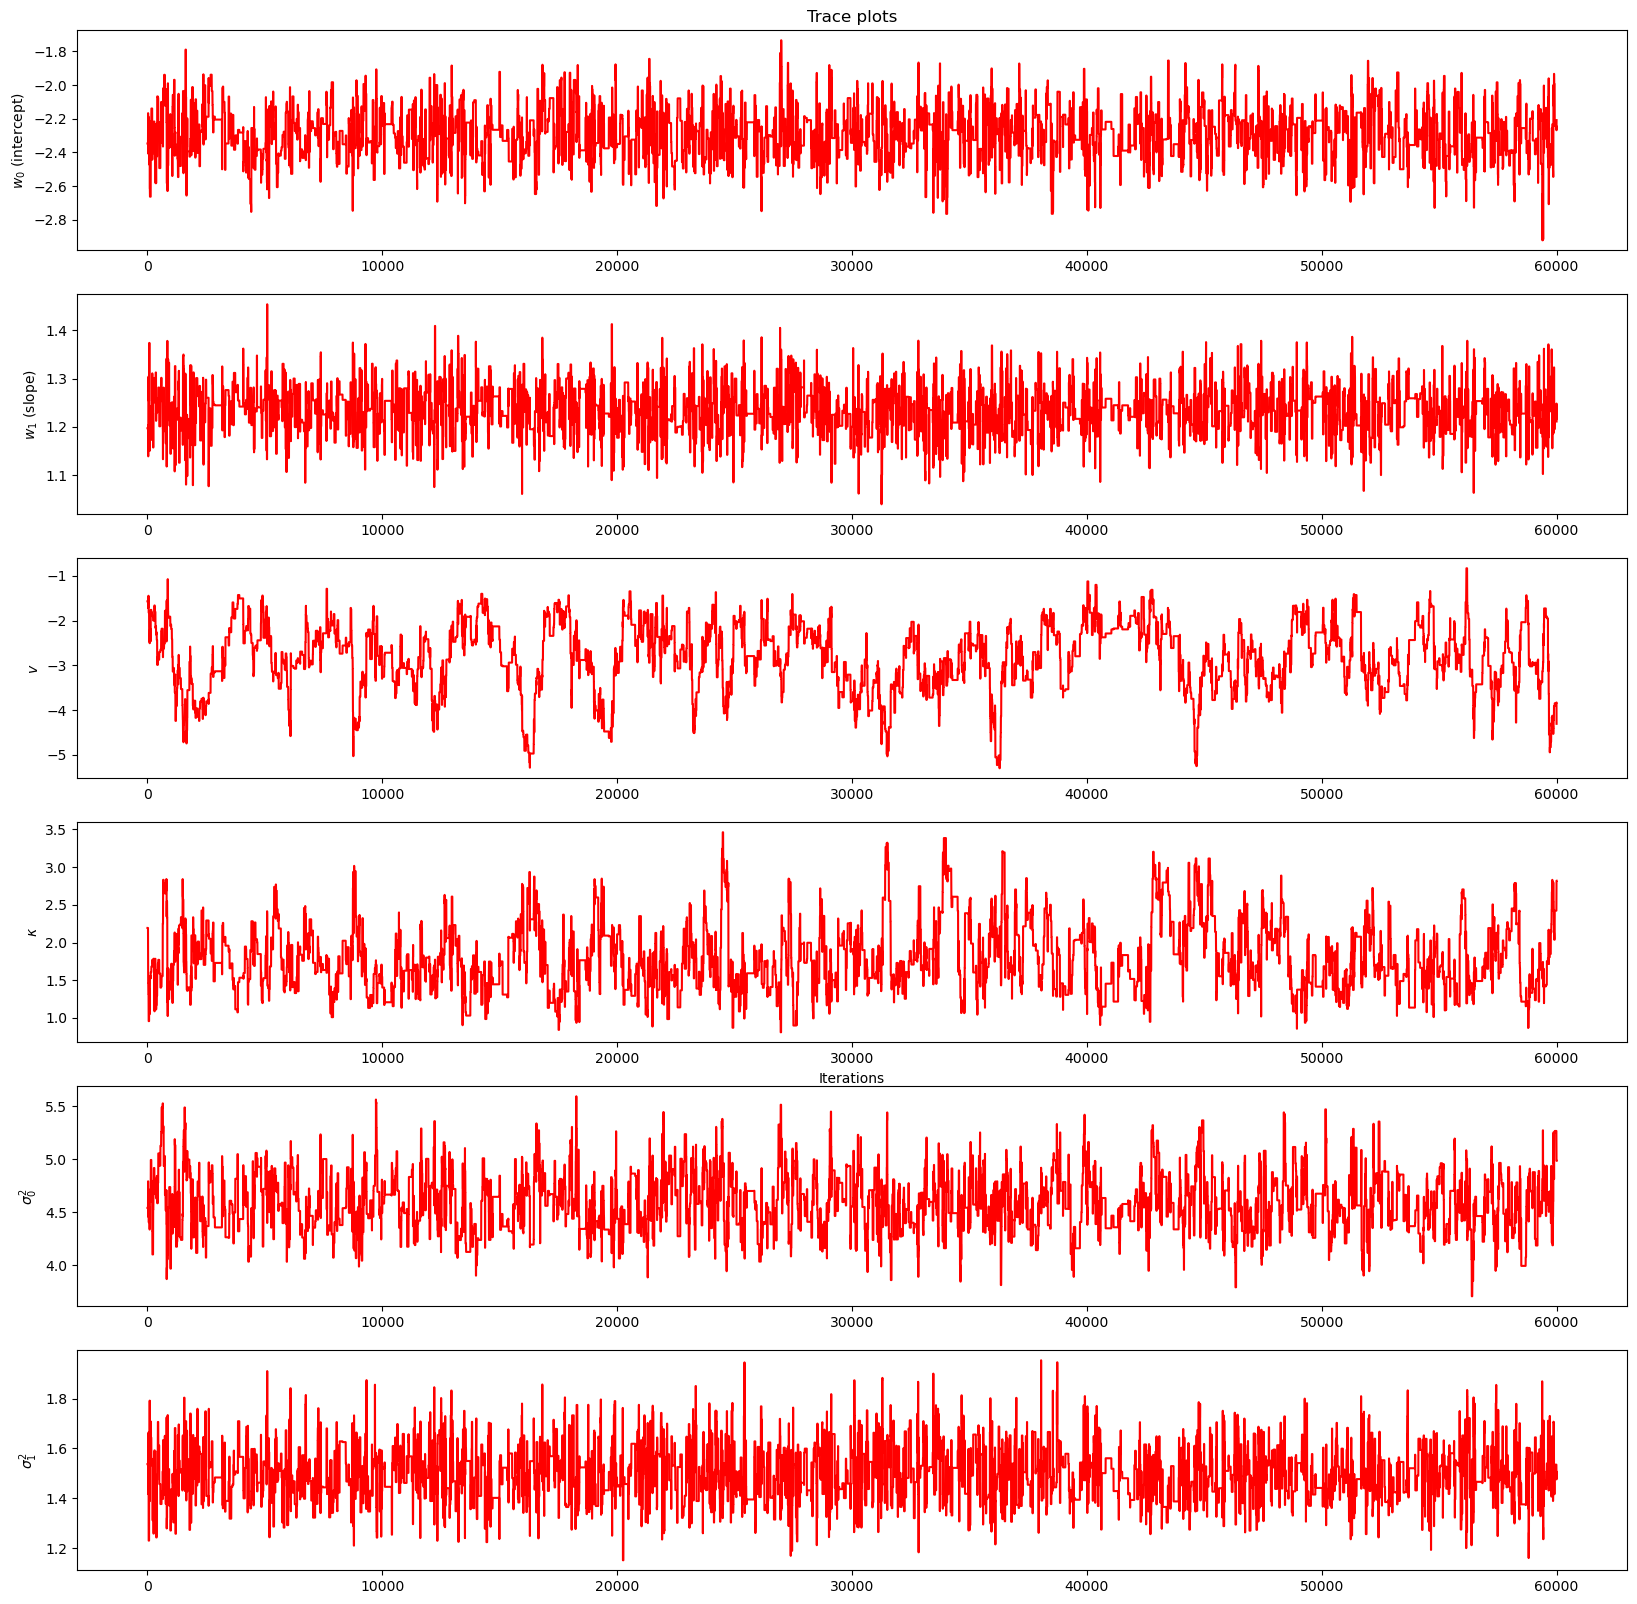

In [13]:
# extract
w_samples = thetas[:, :2]
v_samples = thetas[:, 2]
r_samples = thetas[:, 3]
sigma_squared_0_samples = thetas[:, 4]
sigma_squared_1_samples = thetas[:, 5]

# plot
fig, axes = plt.subplots(6, 1, figsize=(20, 20))

axes[0].plot(w_samples[:, 0], 'r-')
axes[0].set(ylabel='$w_0$ (intercept)', title='Trace plots')

axes[1].plot(w_samples[:, 1], 'r-')
axes[1].set(ylabel='$w_1$ (slope)')

axes[2].plot(v_samples, 'r-')
axes[2].set(ylabel='$v$')

axes[3].plot(r_samples, 'r-')
axes[3].set(ylabel='$\\kappa$')
axes[3].set_xlabel('Iterations')

axes[4].plot(sigma_squared_0_samples, 'r-')
axes[4].set(ylabel='$\sigma_0^2$')

axes[5].plot(sigma_squared_1_samples, 'r-')
axes[5].set(ylabel='$\sigma_1^2$')